# Experiment 1

In this experiment I create 2 models with the same number of parameters but one is with activation function and the second one is without activation funciton. I train neural networks to make function aproximation. The function I have chosen is sin. I test the networks for different number of neurons in hidden layers and then I check how the activation functions affect neural network while training. Finally I compare the results


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


def train(model, X_train, y_train, loss_fn, device=None, epochs = 100, lr=0.1):
    optimizer = torch.optim.Adam(params=model.parameters(), 
                            lr=lr)

    X_train, y_train = X_train.to(device), y_train.to(device)

    for _ in range(epochs):
        model.train()

        y_logits = model(X_train).squeeze() 

        loss = loss_fn(y_logits,
                    y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

def test(model, X_test, y_test, loss_fn):
    model.eval()
    with torch.inference_mode():
        test_out = model(X_test).squeeze() 
        test_loss = loss_fn(test_out,
                            y_test)
    
    return test_loss

def func(x):
    return np.sin(4 * np.pi * x)

def make_sinus_wave(n_samples=100, noise=0.05, random_state=None):
    rng = np.random.RandomState(random_state)

    x_values = rng.rand(n_samples)

    X = x_values.reshape(-1, 1)
    y = func(x_values) + noise * rng.randn(n_samples)

    return X, y

## Data

I decided to use sinusiodal wave as a dataset. The task for neural networks is to approximate this function.

### Showing data


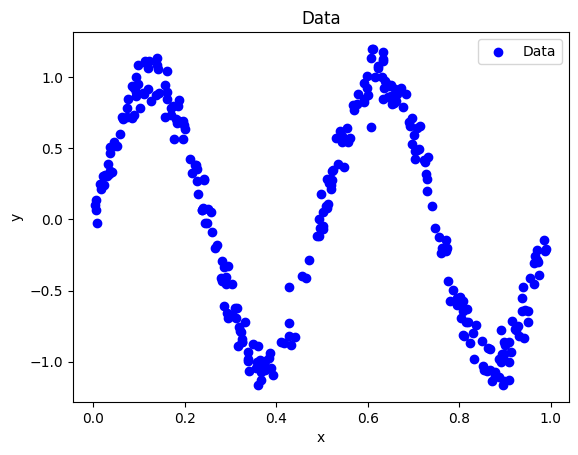

In [84]:
X, y = make_sinus_wave(n_samples=300, noise=0.1, random_state=42)

plt.scatter(X, y, label='Data', c='b')

plt.title("Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Spliting the data into 2 sets


In [85]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test =  train_test_split(X, 
                        y, 
                        test_size=0.2
                    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


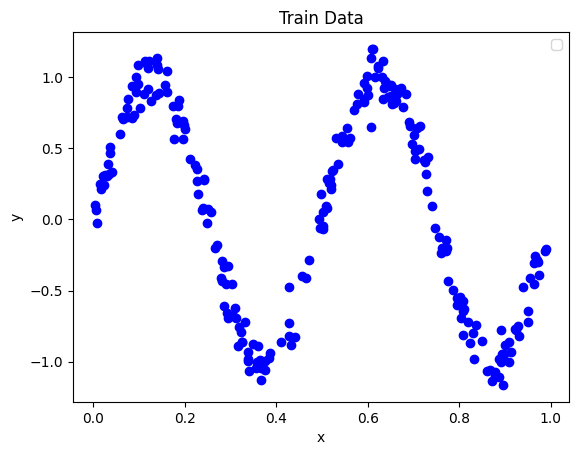

In [86]:
plt.scatter(X_train, y_train, c='b')
plt.title("Train Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


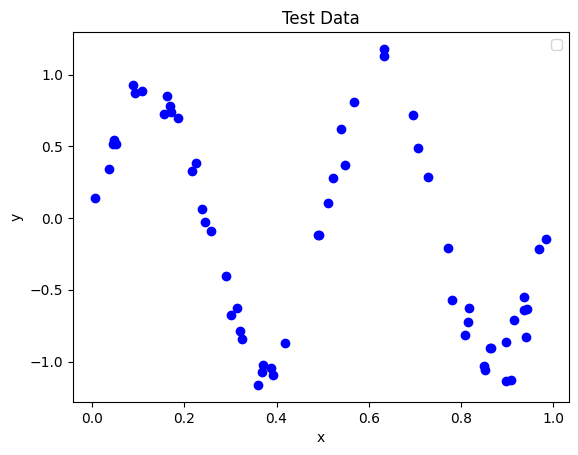

In [87]:
plt.scatter(X_test, y_test, c='b')
plt.title("Test Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Training

### Overview

In this section I train 16 different neural networks and save the results. They differ in number of neurons in the hidden layer and on half of them ReLU activation function is applied.

### Training hyperparameters

learning rate: 0.01

epochs: 10000


In [88]:
results = {}

for number_of_neurons in [2, 4, 8, 16, 32, 64, 128, 256]:

    torch.manual_seed(42)
    model1 = nn.Sequential(
        nn.Linear(1, number_of_neurons),
        nn.Linear(number_of_neurons, 1),
    )
    
    torch.manual_seed(42)
    model2 = nn.Sequential(
        nn.Linear(1, number_of_neurons),
        nn.ReLU(),
        nn.Linear(number_of_neurons, 1),
    )
    
    model1 = train(model1, X_train, y_train, nn.MSELoss(), epochs=10000, lr=0.01)
    model2 = train(model2, X_train, y_train, nn.MSELoss(), epochs=10000, lr=0.01)

    model1_test_loss = test(model1, X_test, y_test, nn.MSELoss())
    model2_test_loss = test(model2, X_test, y_test, nn.MSELoss())

    results[f"model1_{number_of_neurons}"] = {
        "test loss": model1_test_loss,
        "model": model1
    }
    
    results[f"model2_{number_of_neurons}"] = {
        "test loss": model2_test_loss,
        "model": model2
    }


In [89]:
def stringify_results(results):
    s = ""
    for model_name, params in results.items():
        s += model_name + "\n"
        for k, v in params.items():
            if k != 'model':
                s += f'\t{k}: {v}\n'
    return s

str_results = stringify_results(results)

with open("experiment2a.txt", 'w+') as f:
    f.write(str_results)

In [90]:
def plot_decision_boundary(model):
    x_values = np.linspace(0, 1, 100)
    X = torch.from_numpy(x_values).type(torch.float)
    plt.title("Comparison of Original and Predicted Data")
    plt.scatter(x=X, 
                y=func(X),
                c='b',
                label='True values')
    
    plt.scatter(x=X, 
                y=model(X.unsqueeze(-1)).flatten().detach().numpy(),
                c='r',
                label='Predicted values')
    plt.legend()
    plt.show()

### Displaying the best model with none activation function.


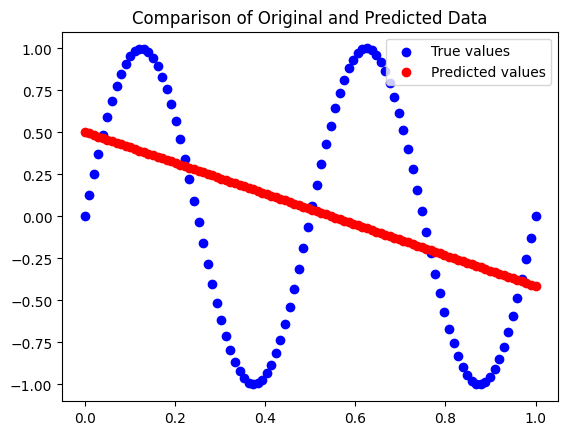

In [91]:
plot_decision_boundary(min(results.items(), key=lambda x: x[1]['test loss'] if 'model1' in x[0] else float('inf'))[1]["model"])

In [100]:
min(results.items(), key=lambda x: x[1]['test loss'] if 'model1' in x[0] else float('inf'))[0]

'model1_8'

### Displaying the best model with ReLU activation function.


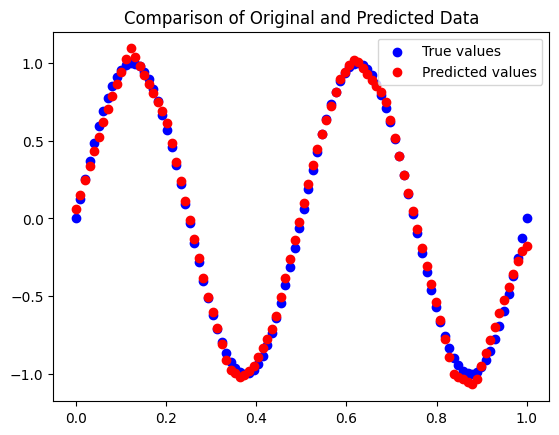

In [92]:
x = np.linspace(0, 1, 100)

plot_decision_boundary(min(results.values(), key=lambda x: x['test loss'])["model"])

In [93]:
min(results.items(), key=lambda x: x[1]['test loss'])[0]

'model2_256'

In [94]:
min(results.items(), key=lambda x: x[1]['test loss'])[1]['test loss'].item()

0.011234394274652004

### Training the model with GELU activation function


In [95]:
results2 = {}

for number_of_neurons in [2, 4, 8, 16, 32, 64, 128, 256]:
    torch.manual_seed(42)
    model = nn.Sequential(
        nn.Linear(1, number_of_neurons),
        nn.GELU(),
        nn.Linear(number_of_neurons, 1),
    )
    
    model = train(model, X_train, y_train, nn.MSELoss(), epochs=10000, lr=0.01)

    model_test_loss = test(model, X_test, y_test, nn.MSELoss())

    results2[f"model_{number_of_neurons}"] = {
        "test loss": model_test_loss,
        "model": model
    }

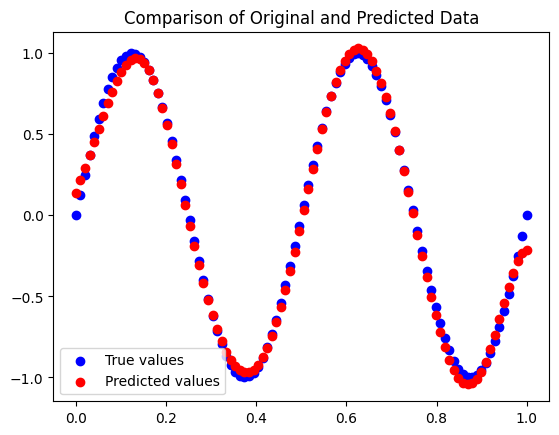

In [96]:
x = np.linspace(0, 1, 100)

plot_decision_boundary(min(results2.values(), key=lambda x: x['test loss'])["model"])

In [97]:
min(results2.items(), key=lambda x: x[1]['test loss'])[0]

'model_4'

In [98]:
min(results2.items(), key=lambda x: x[1]['test loss'])[1]['test loss'].item()

0.010816454887390137

As we can see in this example using GELU activation function let us to use less parameters and we got better fitted curve.


In [99]:
str_results = stringify_results(results2)

with open("experiment2b.txt", 'w+') as f:
    f.write(str_results)